In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
import pickle
import multiprocessing as mp
import arviz as az

matplotlib.rcParams.update({'font.size': 18})
from joblib import delayed, Parallel
from collections import defaultdict, OrderedDict
import pymc3 as pm
from pymc3.ode import DifferentialEquation
from utils.generic import init_params
from main.seir.optimiser import Optimiser
from models.seir.seir_testing import SEIR_Testing
from data.processing import get_district_time_series
from data.dataloader import get_covid19india_api_data
from theano.ifelse import ifelse
from theano import tensor as T
from theano import tensor as T, function, printing
from theano import function
import theano
theano.config.compute_test_value='ignore'
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"



## Load covid19 data

In [4]:
dataframes = get_covid19india_api_data()

In [5]:
dataframes.keys()

dict_keys(['df_tested', 'df_statewise', 'df_india_time_series', 'df_districtwise', 'df_raw_data_old', 'df_raw_data', 'df_deaths_recoveries', 'df_districts', 'df_travel_history', 'df_resources'])

In [6]:
regions = [('Delhi', ''), ('Karnataka', 'Bengaluru Urban'), ('Maharashtra', 'Mumbai'), ('Maharashtra', 'Pune'), ('Gujarat', 'Ahmedabad'), ('Rajasthan', 'Jaipur')]
state, district = regions[2]
df_district = get_district_time_series(dataframes, state=state, district=district, use_dataframe='districts_daily')

/Users/mihirkulkarni/.pyenv/versions/3.6.9/envs/covid3.6/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


## Create train-val splits

In [7]:
df_train = df_district.iloc[:-5, :]
df_val = df_district.iloc[-5:, :]

In [8]:
df_train, df_val

(          state district       date hospitalised total_infected deceased  \
 0   Maharashtra   Mumbai 2020-04-24         3555           4205      167   
 1   Maharashtra   Mumbai 2020-04-25         4388           5049      191   
 2   Maharashtra   Mumbai 2020-04-26         4652           5407      204   
 3   Maharashtra   Mumbai 2020-04-27         4547           5407      219   
 4   Maharashtra   Mumbai 2020-04-28         5239           6169      219   
 5   Maharashtra   Mumbai 2020-04-29         5438           6644      270   
 6   Maharashtra   Mumbai 2020-04-30         5679           7061      290   
 7   Maharashtra   Mumbai 2020-05-01         5673           7061      296   
 8   Maharashtra   Mumbai 2020-05-02         6903           8359      322   
 9   Maharashtra   Mumbai 2020-05-03         7227           8800      343   
 10  Maharashtra   Mumbai 2020-05-04         7227           8800      343   
 11  Maharashtra   Mumbai 2020-05-05         8163           9945      387   

In [9]:
df_train.to_csv('df_train.csv')
df_val.to_csv('df_val.csv')

## Loss Calculation Functions

In [10]:
def _calc_rmse(y_pred, y_true, log=True):
    if log:
        y_true = np.log(y_true)
        y_pred = np.log(y_pred)
    loss = np.sqrt(np.mean((y_true - y_pred)**2))
    return loss

def _calc_mape(y_pred, y_true):
    y_pred = y_pred[y_true > 0]
    y_true = y_true[y_true > 0]

    ape = np.abs((y_true - y_pred + 0) / y_true) *  100
    loss = np.mean(ape)
    return loss

def calc_loss_dict(states_time_matrix, df, method='rmse', rmse_log=False):
    pred_hospitalisations = states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8]
    pred_recoveries = states_time_matrix[9]
    pred_fatalities = states_time_matrix[10]
    pred_infectious_unknown = states_time_matrix[2] + states_time_matrix[4]
    pred_total_cases = pred_hospitalisations + pred_recoveries + pred_fatalities
    
    if method == 'rmse':
        if rmse_log:
            calculate = lambda x, y : _calc_rmse(x, y)
        else:
            calculate = lambda x, y : _calc_rmse(x, y, log=False)
    
    if method == 'mape':
            calculate = lambda x, y : _calc_mape(x, y)
    
    losses = {}
#     losses['hospitalised'] = calculate(pred_hospitalisations, df['Hospitalised'])
#     losses['recovered'] = calculate(pred_recoveries, df['Recovered'])
#     losses['fatalities'] = calculate(pred_fatalities, df['Fatalities'])
#     losses['active_infections'] = calculate(pred_infectious_unknown, df['Active Infections (Unknown)'])
    losses['total'] = calculate(pred_total_cases, df['total_infected'])
    
    return losses

def calc_loss(states_time_matrix, df, method='rmse', rmse_log=False):
    losses = calc_loss_dict(states_time_matrix, df, method, rmse_log)
#     loss = losses['hospitalised'] + losses['recovered'] + losses['total'] + losses['active_infections']
    loss = losses['total']
    return loss

## Prediction Interval calculator

In [11]:
def get_PI(pred_dfs, date, key, multiplier=1.96):
    pred_samples = list()
    for df in pred_dfs:
        pred_samples.append(df.loc[date, key])
        
    mu = np.array(pred_samples).mean()
    sigma = np.array(pred_samples).std()
    low = mu - multiplier*sigma
    high = mu + multiplier*sigma
    return mu, low, high

## Define new class

In [12]:


class SEIR_Test_pymc3(SEIR_Testing):
    def __init__(self,  *args, **kwargs):
        super().__init__( *args, **kwargs)
    def get_derivative(self, y, t, p):
        # Init state variables
        #for i, _ in enumerate(y):
        #for i in range(11):
        #    y[i] = ifelse(T.lt(y[i], 0), y[i], np.float64(0))
        #    y[i] = max(y[i], 0)
        zero = T.cast(0.0, 'float64')
        for i in range(11):
            T.set_subtensor(y[i], ifelse(T.gt(y[i], zero), y[i], zero))
        # Init time parameters and probabilities
        for key in self.vanilla_params:
            setattr(self, key, self.vanilla_params[key])
        for key in self.testing_params:
            suffix = '_D' if key in self.vanilla_params else ''
            setattr(self, key + suffix, self.testing_params[key])
            
        
        ## Set up variables using `y` and `p`
        
        S = y[0]
        E = y[1]
        I = y[2]
        D_E = y[3]
        D_I = y[4]
        R_mild = y[5]
        R_severe_home = y[6]
        R_severe_hosp = y[7]
        R_fatal = y[8]
        C = y[9]
        D = y[10]
        
        # p
    
        self.R0 = p[0]
        self.T_inc = p[1]
        self.T_inf = p[2]
        self.T_recov_severe = p[3]
        self.P_severe = p[4]
        self.intervention_amount = p[5]
        
        #Define variables  
        if self.post_lockdown_R0 == None:
            self.post_lockdown_R0 = self.lockdown_R0

        self.P_mild = 1 - self.P_severe - self.P_fatal

        # define testing related parameters
        self.T_inf_detected = self.T_inf
        self.T_inc_detected = self.T_inc

        self.P_mild_detected = self.P_mild
        self.P_severe_detected = self.P_severe
        self.P_fatal_detected = self.P_fatal
        #self.T_trans_D = self.T_trans
  
        #TODO incorporate lockdown R0 code
        #T.set_subtensor(self.R0, ifelse(T.gt(t, self.lockdown_removal_day), self.R0 , self.post_lockdown_R0))
        # Modelling the behaviour lockdown
        #elif t >= self.lockdown_day:
        #    self.R0 = self.lockdown_R0
        #T.set_subtensor(self.R0, ifelse(T.gt(t, self.lockdown_day), self.R0, self.lockdown_R0))
        # Modelling the behaviour pre-lockdown
        #else:
        #    self.R0 = self.pre_lockdown_R0
        #T.set_subtensor(self.R0, ifelse(T.gt(y[i], zero), self.R0, self.pre_lockdown_R0))
        self.T_trans = self.T_inf/self.R0
        self.T_trans_D = self.T_inf_D/self.R0
        
       
        # Write differential equations
        dS = - I * S / (self.T_trans) - (self.q / self.T_trans_D) * (S * D_I) # # S
        #dS = - y[2] * y[0]*p[0]/p[2]  - self.q*p[2] * (y[0] * y[4])
        dE = I * S / (self.T_trans) + (self.q / self.T_trans_D) * (S * D_I) - (E/ self.T_inc) - (self.theta_E * self.psi_E * E) # E
        dI = E / self.T_inc - I / self.T_inf - (self.theta_I * self.psi_I * I) # I
        dD_E = (self.theta_E * self.psi_E * E) - (1 / self.T_inc_D) * D_E# D_E
        dD_I = (self.theta_I * self.psi_I * I) + (1 / self.T_inc_D) * D_E - (1 / self.T_inf_D) * D_I # D_I 
        dR_mild = (1/self.T_inf)*(self.P_mild*I) + (1/self.T_inf_D)*(self.P_mild_D*D_I) - R_mild/self.T_recov_mild  # R_mild
        dR_severe_home = (1/self.T_inf)*(self.P_severe*I) + (1/self.T_inf_D)*(self.P_severe_D*D_I) - R_severe_home/self.T_hosp  # R_severe_home
        dR_severe_hosp = R_severe_home/self.T_hosp - R_severe_hosp/self.T_recov_severe# R_severe_hosp
        dR_fatal = (1/self.T_inf)*(self.P_fatal*I) + (1/self.T_inf_D)*(self.P_fatal_D*D_I) - R_fatal/self.T_death # R_fatal
        dC = R_mild/self.T_recov_mild + R_severe_hosp/self.T_recov_severe # C
        dD = R_fatal/self.T_death # D

        return [dS, dE, dI, dD_E, dD_I, dR_mild, dR_severe_home, dR_severe_hosp, dR_fatal, dC, dD]
    
    def solve_ode(self, total_no_of_days=200, time_step=1, method='Radau'):
        num_steps = 5
        num_states = 11
        burn_in = 500
        total_steps = 1000
        t_start = 0
        t_final = total_no_of_days
        time_steps = np.arange(t_start, total_no_of_days + time_step, time_step)
        
        sir_model = DifferentialEquation(
                func=self.get_derivative,
                times=time_steps,
                n_states= num_states,
                n_theta=6,
                t0 = t_start
            )
        state_init_values_arr = [self.state_init_values[x] for x in self.state_init_values]

        sol = solve_ivp(self.get_derivative, [t_start, t_final], 
                        state_init_values_arr, method=method, t_eval=time_steps)

        return sol

    def return_predictions(self, sol):
        states_time_matrix = (sol.y*self.vanilla_params['N']).astype('int')
        dataframe_dict = {}
        for i, key in enumerate(self.state_init_values.keys()):
            dataframe_dict[key] = states_time_matrix[i]
        
        df_prediction = pd.DataFrame.from_dict(dataframe_dict)
        df_prediction['date'] = pd.date_range(self.starting_date, self.starting_date + datetime.timedelta(days=df_prediction.shape[0] - 1))
        columns = list(df_prediction.columns)
        columns.remove('date')
        df_prediction = df_prediction[['date'] + columns]

        df_prediction['hospitalised'] = df_prediction['R_severe_home'] + df_prediction['R_severe_hosp'] + df_prediction['R_fatal']
        df_prediction['recovered'] = df_prediction['C']
        df_prediction['deceased'] = df_prediction['D']
        df_prediction['infectious_unknown'] = df_prediction['I'] + df_prediction['D_I']
        df_prediction['total_infected'] = df_prediction['hospitalised'] + df_prediction['recovered'] + df_prediction['deceased']
        return df_prediction


In [13]:
x = T.scalar('x')
z = T.scalar('z')
xplus = ifelse(T.lt(x, z), x, z)
xplus.eval({x:1,z:0})

array(0.)

# Set up model parameters

In [40]:
SEIR_Test_obj = SEIR_Test_pymc3()
num_patients = SEIR_Test_obj.__dict__['vanilla_params']['N']
init_vals = list(SEIR_Test_obj.__dict__['state_init_values'].values())
num_states = 11
num_params = 6
num_steps = 21
num_train_steps = 7


burn_in = 1000
mcmc_steps = 2000

observed = df_train['total_infected'][-num_train_steps:]


In [35]:
observed 

16    13739
17    14521
18    14947
19    15747
20    16738
21    17671
22    18555
Name: total_infected, dtype: object

# Run model

In [36]:
sir_model = DifferentialEquation(
    func=SEIR_Test_obj.get_derivative,
    times=np.arange(0, num_steps, 1),
    n_states= num_states,
    n_theta= num_params,
    t0 = 0
)

In [19]:
with pm.Model() as model:
    R0 = pm.Uniform("R0", lower =1, upper=3)#(1.6, 3)
    T_inc = pm.Uniform("T_inc", 1, 5)#(3, 4)
    T_inf = pm.Uniform("T_inf", 1, 4)#(3, 4)
    T_recov_severe = pm.Uniform("T_recov_severe ", 9, 20)
    P_severe = pm.Uniform("P_severe", 0.3, 0.99)
    intervention_amount = pm.Uniform("intervention_amount", 0.3, 1)
    
    ode_solution = sir_model(y0=init_vals , theta=[R0, T_inc, T_inf, T_recov_severe, P_severe, intervention_amount])
    # The ode_solution has a shape of (n_times, n_states)
    
    predictions = ode_solution[:num_train_steps]
    hospitalised = predictions[:,6] + predictions[:,7] + predictions[:,8]
    recovered = predictions[:,9]
    deceased = predictions[:,10]
    total_infected = hospitalised + recovered + deceased
    total_infected = total_infected * num_patients 
    #sigma = pm.HalfNormal('sigma',
    #                      sigma=observed.std(),
    #                      shape=num_params)
    Y = pm.Normal('Y', mu = total_infected, observed=observed)
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample(mcmc_steps, tune=burn_in , target_accept=0.9, cores=1)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [intervention_amount, P_severe, T_recov_severe , T_inf, T_inc, R0]
Sampling chain 1, 0 divergences: 100%|██████████| 150/150 [02:01<00:00,  1.23it/s]
The acceptance probability does not match the target. It is 0.9623313777373232, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
100%|██████████| 200/200 [00:21<00:00,  9.11it/s]


In [38]:
trace 

<MultiTrace: 2 chains, 100 iterations, 12 variables>

In [ ]:
printing_op = printing.Print('vector', attrs = [ 'shape' ])
shape_infected = printing_op(total_infected)
shape_sigma = printing_op(sigma)
printval = printing.Print('vector')
printval(total_infected* num_patients)

# Analyse runs

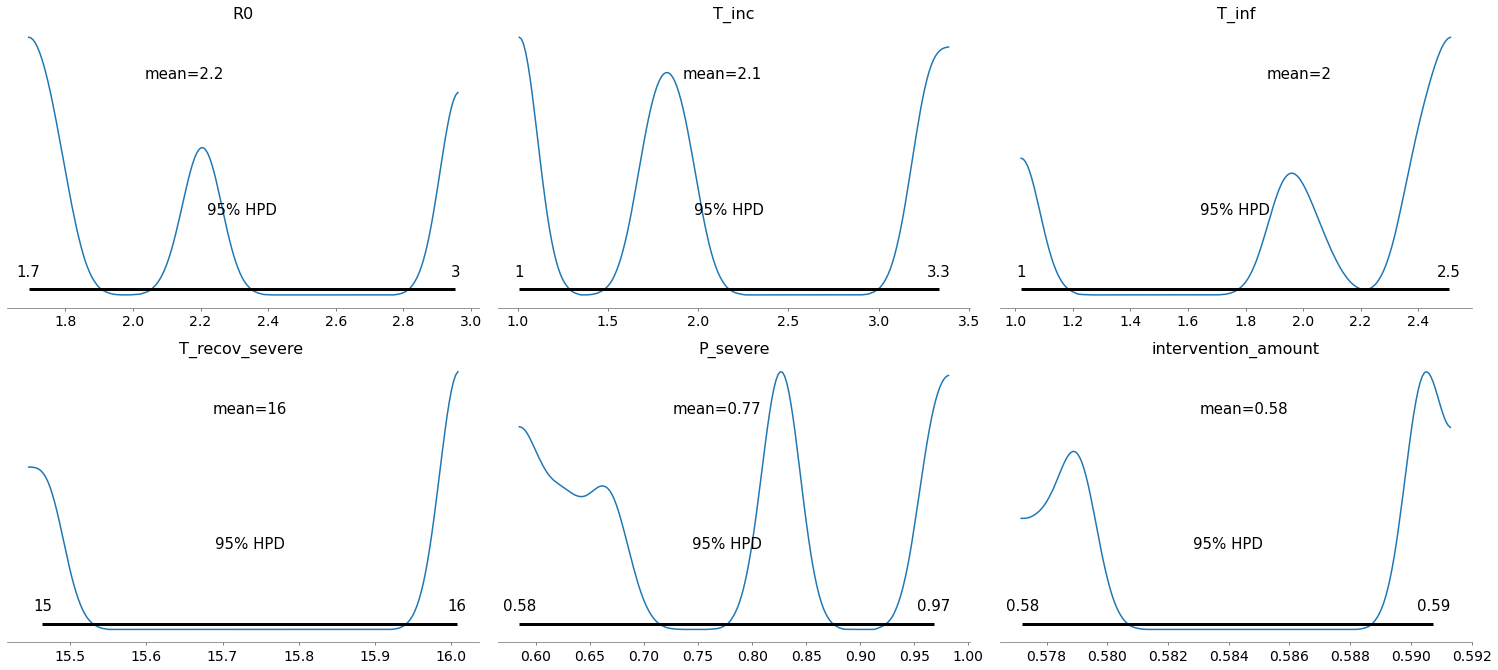

In [21]:
with model:
    data = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)
    az.plot_posterior(data,round_to=2, credible_interval=0.95)

In [ ]:
#pm.forestplot(trace)

In [39]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
R0,2.151,0.465,1.691,2.953,0.266,0.210,3.0,3.0,3.0,12.0,1.94
T_inc,2.131,0.860,1.009,3.332,0.483,0.398,3.0,3.0,3.0,12.0,2.40
T_inf,1.986,0.543,1.020,2.505,0.310,0.254,3.0,3.0,3.0,12.0,2.53
T_recov_severe,15.735,0.267,15.464,16.008,0.181,0.151,2.0,2.0,3.0,16.0,1.89
P_severe,0.768,0.137,0.585,0.968,0.084,0.067,3.0,3.0,3.0,12.0,2.78
intervention_amount,0.585,0.006,0.577,0.591,0.004,0.003,2.0,2.0,3.0,12.0,2.38


In [ ]:
pm.plots.traceplot(trace)

In [ ]:
pm.plots.autocorrplot(trace)

In [23]:
final_runs = trace#[burn_in:]

## Visualize the samples and intervals

In [41]:
#def visualize(): 
data_split = df_district.copy()
optimiser = Optimiser()
default_params = optimiser.init_default_params(data_split)

#combined_acc = list()
#for k, run in enumerate(mcmc):
#    burn_in = int(len(run) / 2)
#    combined_acc += run[0][burn_in:]

n_samples = 1000
sample_indices = np.random.uniform(0, len(final_runs), n_samples)

pred_dfs = list()
for i in tqdm(sample_indices):
    pred_dfs.append(optimiser.solve(final_runs[int(i)], default_params, data_split))

for df in pred_dfs:
    df.set_index('date', inplace=True)

result = pred_dfs[0].copy()
for col in result.columns:
    result["{}_low".format(col)] = ''
    result["{}_high".format(col)] = ''

for date in tqdm(pred_dfs[0].index):
    for key in pred_dfs[0]:
        result.loc[date, key], result.loc[date, "{}_low".format(key)], result.loc[date, "{}_high".format(key)] = get_PI(pred_dfs, date, key)

data_split.set_index("date", inplace=True)


100%|██████████| 28/28 [00:06<00:00,  4.18it/s]


In [43]:
final_runs[int(i)]

{'R0_interval__': -0.451538681699726,
 'T_inc_interval__': -1.4753059569423739,
 'T_inf_interval__': -0.1480400610143987,
 'T_recov_severe _interval__': 0.35940006440322536,
 'P_severe_interval__': 0.1100744196395917,
 'intervention_amount_interval__': -0.3430923831324991,
 'R0': 1.7779899860621118,
 'T_inc': 1.7445498957483085,
 'T_inf': 2.3891722873953873,
 'T_recov_severe ': 15.47784718695743,
 'P_severe': 0.663968688604508,
 'intervention_amount': 0.5905409474418144}

In [37]:
optimiser.solve(final_runs[int(i)], default_params, data_split)

,date,S,E,I,D_E,D_I,R_mild,R_severe_home,R_severe_hosp,R_fatal,C,D,hospitalised,recovered,deceased,infectious_unknown,total_infected
0,2020-04-24,9995795,0,4205,0,0,0,0,0,0,0,0,0,0,0,4205,0
1,2020-04-25,9991148,3567,3733,0,0,521,0,936,30,59,0,966,59,0,3733,1025
2,2020-04-26,9986110,6001,4657,0,0,1044,1,1891,62,229,1,1954,229,1,4657,2184
3,2020-04-27,9979432,8714,6392,0,0,1707,1,3113,104,529,4,3218,529,4,6392,3751
4,2020-04-28,9970135,12338,8957,0,0,2608,2,4782,162,1003,8,4946,1003,8,8957,5957
5,2020-04-29,9957141,17361,12582,0,0,3851,3,7089,243,1712,14,7335,1712,14,12582,9061
6,2020-04-30,9938872,24399,17691,0,0,5585,4,10313,356,2751,24,10673,2751,24,17691,13448
7,2020-05-01,9913212,34263,24870,0,0,8011,6,14827,515,4255,37,15348,4255,37,24870,19640
8,2020-05-02,9877398,47993,34891,0,0,11394,8,21123,737,6395,57,21868,6395,57,34891,28320
9,2020-05-03,9827267,67134,48919,0,0,16135,12,29953,1048,9444,84,31013,9444,84,48919,40541


In [32]:
data_split['total_infected'], result['total_infected']

(0      4205
 1      5049
 2      5407
 3      5407
 4      6169
 5      6644
 6      7061
 7      7061
 8      8359
 9      8800
 10     8800
 11     9945
 12    10714
 13    11394
 14    12142
 15    12864
 16    13739
 17    14521
 18    14947
 19    15747
 20    16738
 21    17671
 22    18555
 23    20150
 24    21335
 25    21335
 26    24118
 27    25500
 Name: total_infected, dtype: object,
 date
 2020-04-24          0.000
 2020-04-25       1270.828
 2020-04-26       2882.720
 2020-04-27       5421.090
 2020-04-28       9660.508
 2020-04-29      16948.121
 2020-04-30      29773.100
 2020-05-01      52533.238
 2020-05-02      92389.298
 2020-05-03     159120.831
 2020-05-04     261372.609
 2020-05-05     394653.300
 2020-05-06     536864.210
 2020-05-07     674124.549
 2020-05-08     800794.716
 2020-05-09     917813.150
 2020-05-10    1029883.839
 2020-05-11    1143366.763
 2020-05-12    1264657.473
 2020-05-13    1399431.118
 2020-05-14    1552499.235
 2020-05-15    1727474.85

# Plot graphs

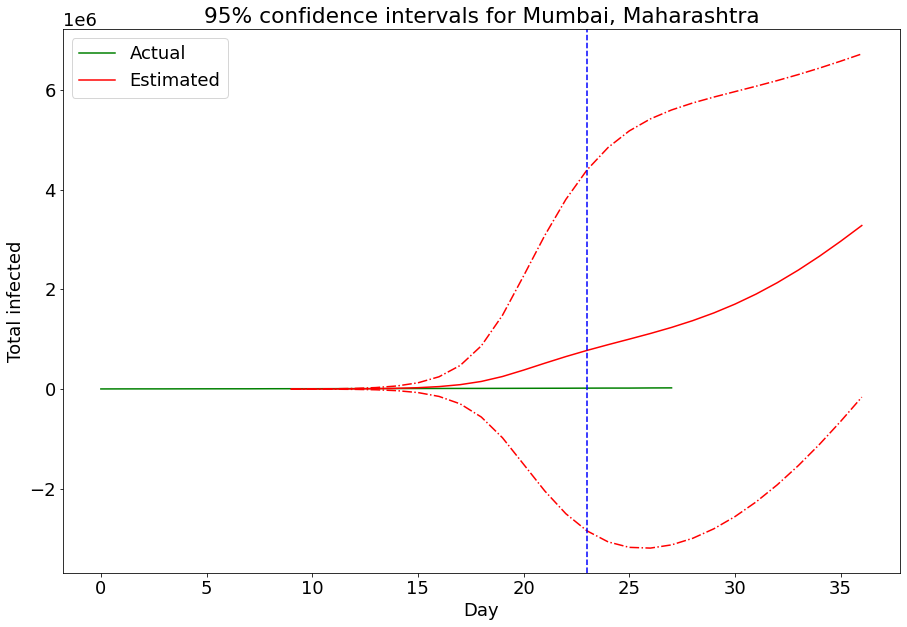

In [42]:
x_plot = range(len(df_train) - len(observed)-7, len(df_train) - len(observed) + num_steps)
plt.figure(figsize=(15, 10))
plt.plot(data_split['total_infected'].tolist(), c='g', label='Actual')
plt.plot( x_plot, result['total_infected'].tolist(), c='r', label='Estimated')
plt.plot(x_plot, result['total_infected_low'].tolist(), c='r', linestyle='dashdot')
plt.plot(x_plot, result['total_infected_high'].tolist(), c='r', linestyle='dashdot')
plt.axvline(x=len(df_train), c='b', linestyle='dashed')
plt.xlabel("Day")
plt.ylabel("Total infected")
plt.legend()
plt.title("95% confidence intervals for {}, {}".format(district, state))

plt.savefig('./mcmc_confidence_intervals_{}_{}.png'.format(district, state))
plt.show()

In [ ]:
visualize()